# Processing and analyzing data from a roving detector



This tutorial demonstrates how to process and analyze data from a rover using the Cosmic Ray Neutron Python (CRNPy) library. The steps include loading the data, converting geographical coordinates to Cartesian coordinates, normalizing neutron counts, correcting for atmospheric effects, and visualizing the results.

First import the required packages.

In [1]:
# Import modules
import numpy as np
import pandas as pd
from crnpy import crnpy
import matplotlib.pyplot as plt


Load the data stored in the [.csv file](https://raw.githubusercontent.com/soilwater/crnpy/main/docs/examples/rover/gypsum_transect_01_may_2018.KSU).

In [2]:
# Sample dataset
filepath = "https://raw.githubusercontent.com/soilwater/crnpy/main/docs/examples/rover/gypsum_transect_01_may_2018.KSU"
col_names = 'RecordNum,Date Time(UTC),PTB110_mb,P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,N1Cts,N2Cts,N3Cts,N4Cts,N5Cts,N6Cts,N7Cts,N8Cts,N1ETsec,N3ETsec,N5ETsec,N7ETsec,N1T(C),N1RH,N5T(C),N5RH,GpsUTC,LatDec,LongDec,Alt,Qual,NumSats,HDOP,Speed_kmh,COG,SpeedQuality,strDate'.split(',')

df = pd.read_csv(filepath, skiprows=20, names=col_names)
df['LongDec'] = df['LongDec'] * -1 # Raw data is in absolute values

# Parse timestamps and set as index
df['timestamp'] = pd.to_datetime(df['Date Time(UTC)'])

# Remove rows with missing coordinates
df['LatDec'].replace(0.0, np.nan, inplace=True)
df['LongDec'].replace(0.0, np.nan, inplace=True)
df.dropna(axis=0, subset=['LatDec','LongDec'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Display a few rows to visualize dataset
df.head(3)


,RecordNum,Date Time(UTC),PTB110_mb,P4_mb,P1_mb,T1_C,RH1,T_CS215,RH_CS215,Vbat,...,LongDec,Alt,Qual,NumSats,HDOP,Speed_kmh,COG,SpeedQuality,strDate,timestamp
0,2,2018/05/01 14:15:00,962.95,962.8,961.4,23.2,35.4,20.9,72.7,13.574,...,-97.37195,393.2,2.0,10,0.8,0.00,270.7,A,10518.0,2018-05-01 14:15:00
1,3,2018/05/01 14:16:00,962.88,962.7,961.3,23.3,35.5,21.0,72.7,13.417,...,-97.37197,387.2,2.0,11,0.8,0.00,270.7,A,10518.0,2018-05-01 14:16:00
2,4,2018/05/01 14:17:00,962.64,962.5,961.1,23.4,35.4,21.2,72.2,13.282,...,-97.37199,388.2,1.0,11,0.8,3.89,356.3,A,10518.0,2018-05-01 14:17:00


Next, convert the latitude and longitude to UTM coordinates (x and y). A scatter plot is created to visualize the survey points.

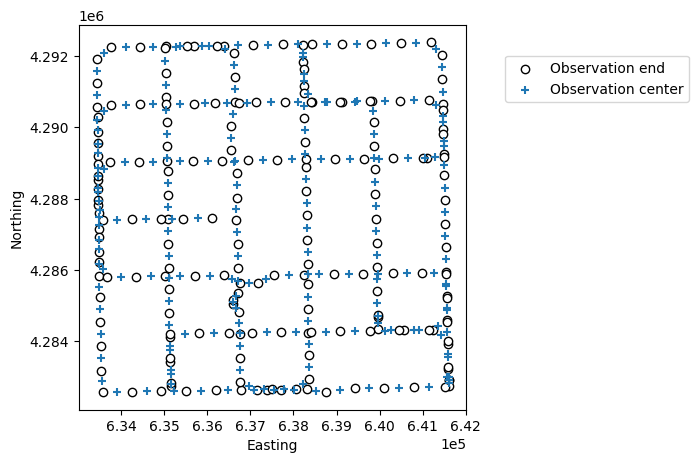

In [3]:
# Convert Lat and Lon to X and Y
df['x'],df['y'] = crnpy.latlon_to_utm(df['LatDec'], df['LongDec'], 14, missing_values=0.0)

# Create figure of survey points
plt.figure(figsize = (5,5))
plt.scatter(df['x'], df['y'], marker='o', edgecolor='k', facecolor='w', label = "Observation end")
df['x'],df['y'] = crnpy.estimate_locations(df['x'], df['y']) # Estimate the center of the observation
plt.scatter(df['x'], df['y'], marker='+', label="Observation center")
plt.ticklabel_format(scilimits = (-5,5))
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.legend(loc=[1.1,.8])
plt.show()


The counts are normalized to counts per minute in case some observations covered a different timespan and total neutron counts are computed.

In [4]:
# Define columns names
counts_colums = ['N1Cts', 'N2Cts', 'N3Cts','N4Cts', 'N5Cts', 'N6Cts', 'N7Cts', 'N8Cts']
cont_times_col = ['N1ETsec', 'N1ETsec', 'N3ETsec','N3ETsec', 'N5ETsec', 'N5ETsec', 'N7ETsec', 'N7ETsec']

# Normalize counts to counts/min
df[counts_colums] = \
    crnpy.adjust_temporal_counts(df[counts_colums], \
                           count_time=60, count_times=df[cont_times_col])

# Compute total neutron counts
df['total_counts'] = crnpy.compute_total_raw_counts(df[counts_colums])


### Neutron count correction 

#### Incommng neutron flux

Find stations with a cutoff rigidity similar to the estimated value based on the latitude and longitude, ensuring that the reference station is under a similar earth electromagnetic field. Note that the station is hardcoded in the second line as `station="NEWK"`. The user is required to manually define this after considering the potential options suggested.

In [5]:
start_date = df.iloc[0]['timestamp']
end_date = df.iloc[-1]['timestamp']

#Find stations with cutoff rigidity similar to estimated by lat,lon
crnpy.find_neutron_monitor(crnpy.cutoff_rigidity(df['LatDec'][0], df['LongDec'][0]), 
                             start_date=start_date, end_date=end_date)

#Download data for one of the similar stations and add to df, with UTC offset for CST, and 2 extra hours in the dataset ends.
incoming_neutrons = crnpy.get_incoming_neutron_flux(start_date=start_date, end_date=end_date, station="NEWK",
                                                    utc_offset=-5, expand_window=2)


Select a station with an altitude similar to that of your location. For more information go to: 'https://www.nmdb.eu/nest/help.php#helpstations

Your cutoff rigidity is 2.99 GV
    STID                          NAME     R  Altitude_m  Period available
13  DRBS                       Dourbes  3.18         225              True
31  MCRL  Mobile Cosmic Ray Laboratory  2.46         200              True
33  MOSC                        Moscow  2.43         200              True
40  NEWK                        Newark  2.40          50              True
20  IRK3                     Irkustk 3  3.64        3000              True
21  IRKT                       Irkustk  3.64         435              True


The incoming neutron flux is interpolated to match the measured timestamps, which is necessary to align the incoming neutron flux data with the rover data.

In [6]:
# Interpolate incomming flux hourly to measured timestamps (~ every minute)
df['incoming_flux'] = crnpy.interpolate_incoming_flux(incoming_neutrons, timestamps=df['timestamp']).values


#### Atmpsheric correction

NaN values in the atmospheric data are filled. The neutron counts are then corrected for atmospheric variables and the incoming neutron flux. Optionally it is possible to pass `incoming_Ref` parameter in [`atm_correction()`](../../../reference/#crnpy.crnpy.atm_correction) to fix a desired value as the reference incoming count for the reference station.

In [7]:
# Fill NaN values in atmospheric data
df[['PTB110_mb', 'RH_CS215', 'T_CS215']] = crnpy.fill_missing_atm(df[['PTB110_mb', 'RH_CS215', 'T_CS215']])

# Correct count by atmospheric variables and incoming flux
df['corrected_counts'] = crnpy.humidity_correction(df['total_counts'],humidity=df['RH_CS215'], temp=df['T_CS215'], Aref=0)
df['corrected_counts'] = crnpy.pressure_correction(df['corrected_counts'], pressure=df['PTB110_mb'], Pref=df['PTB110_mb'].mean(), L=130)
df['corrected_counts'] = crnpy.incoming_flux_correction(df['corrected_counts'], incoming_neutrons=df['incoming_flux'])


C:\Users\jperaza\AppData\Local\anaconda3\envs\crnpy\lib\site-packages\crnpy\crnpy.py:471: UserWarning: Reference incoming neutron flux not provided. Using first value of incoming neutron flux.
  warnings.warn('Reference incoming neutron flux not provided. Using first value of incoming neutron flux.')


The corrected counts are smoothed using a 2D smoothing function. The smoothed counts are then converted to volumetric water content (VWC) using the counts_to_vwc function.

In [11]:
# Smooth variable
df['corrected_smoothed'] = crnpy.spatial_average(df['x'],
                                        df['y'],
                                        df['corrected_counts'],
                                        buffer= 800, method='median', rnd=True)

# Estimate Soil Columetric Water Content
df['VWC'] = crnpy.counts_to_vwc(df['corrected_smoothed'], N0=550, bulk_density=1.3, Wlat=0.03, Wsoc=0.01)

# Drop VWC NaN values before interpolating values
df = df.dropna(subset = ['VWC'])

# Interpolate variable
X_pred, Y_pred, Z_pred = crnpy.interpolate_2d(df['x'],
                                        df['y'],
                                        df['VWC'],
                                        dx=250, dy=250, method='idw')


A gridded map of the Volumetric Water Content (VWC) is created using the interpolated x, y, and VWC values.

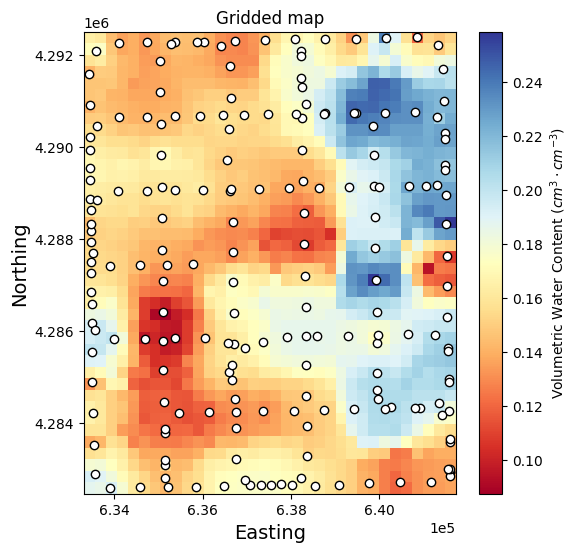

In [12]:
cmap = plt.colormaps['RdYlBu']

plt.figure(figsize=(6,6))
plt.title('Gridded map')
plt.pcolormesh(X_pred, Y_pred, Z_pred, cmap=cmap)
plt.colorbar(label=r"Volumetric Water Content $(cm^3 \cdot cm^{-3})$", location='right')
plt.scatter(df['x'], df['y'], marker='o', edgecolor='k', facecolor='w')
plt.ticklabel_format(scilimits=(-5,5))
plt.xlabel('Easting', size=14)
plt.ylabel('Northing', size=14)
plt.show()


Finally, a contour map of the VWC is created and displayed.

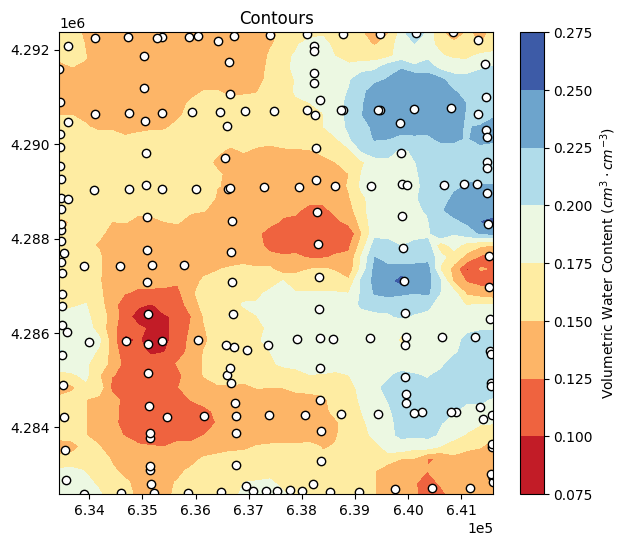

In [13]:
# Show contour map
cmap = plt.colormaps['RdYlBu']

plt.figure(figsize=(7,6))
plt.title('Contours')
plt.contourf(X_pred, Y_pred, Z_pred, cmap=cmap)
plt.ticklabel_format(scilimits=(-5,5))
plt.colorbar(label=r"Volumetric Water Content $(cm^3 \cdot cm^{-3})$", location='right')
plt.scatter(df['x'], df['y'], marker='o', edgecolor='k', facecolor='w')
plt.show()
